# <span style="color:red"><center>Visión por Computadora</center></span>
## <span style="color:red"><center>Introducción a detección de objetos: R-CNN</center></span>

## <span style="color:blue">Introducción</span>

Hasta ahora solo hemos trabajado con la tarea de "Clasificación de objetos", donde en cada imagen tenemos un único enfoque: Definir el objeto principal y reconocer su categoría específica. Y los datasets reflejan esa tarea.

<figure>
<center>
<img src="https://raw.githubusercontent.com/AprendizajeProfundo/Alejandria/main/Vision_Artificial/Imagenes/cifar.png" width="600" height="500" align="center"/> 
</center>
</figure>


Pero, ¿Qué sucede si en una de las imágenes hay más de un objeto principal?. ¿Reconocerá el objeto que estamos buscando, o lo catalogará como falso positivo?
Peor aún, ¿Qué tal si tenemos dos de las categorías que buscamos en la misma imagen?. ¿Cuál de las dos va a reconocer? 
Ahora hagamos esto más complicado y busquemos encontrar el lugar exacto de la imagen donde están dichos objetos.

A partir de este momento, estamos trabajando una tarea distinta. Ahora estamos trabajando con la tarea de "Detección de Objetos". 

<figure>
<center>
<img src="https://raw.githubusercontent.com/AprendizajeProfundo/Alejandria/main/Vision_Artificial/Imagenes/Object-detection.jpg" width="800" height="450" align="center"/> 
</center>
</figure>

Al inicio, no se siente mucho la diferencia entre estas dos ideas, pero ambos problemas implican soluciones distintas.

- En clasificación principalmente nos importa la pregunta binaria "es o no es". En detección nos importa también la locación.
- En clasificación suponemos que, en las imágenes que observamos, vamos a tener un objeto de interés. En Detección, pueden haber varios objetos, y no necesariamente el mismo.


Esta última es la que genera la diferencia más importante. Con la estructura actual que manejamos, es imposible atacar esta tarea. Necesitamos buscar otros medios.


## <span style="color:blue">CNN por regiones(R-CNN)</span>

Este método que vemos aquí de hecho no es tan diferente a cómo detectamos rostros [aquí](../Cuadernos/rostros_opencv.ipynb) y [aquí](../Cuadernos/rostros_cnn.ipynb). De manera general, la idea en la detección de rostros es analizar y definir regiones de interés con base en características de la imagen o un etiquetado manual. Se podría hacer eso, pero debido a las incognitas del número de objetos a encontrar y sus dimensiones, se requerirían muchas regiones

El primer modelo de R-CNN(Region based CNN) se salta ese problema dando un límite a las regiones: solo quedarán los 2000 mejores. la obtención de estas regiones se hace a partir de un "Algoritmo de búsqueda selectiva", definido de la siguiente forma(tomado de [GeeksforGeeks](https://www.geeksforgeeks.org/selective-search-for-object-detection-r-cnn/)):

1. generamos una subsegmentación de la imagen:
<figure>
<center>
<img src="https://raw.githubusercontent.com/AprendizajeProfundo/Alejandria/main/Vision_Artificial/Imagenes/segmentation.png" width="500" height="200" align="center"/> 
</center>
</figure>

2. combinar regiones pequeñas a regiones más grandes a partir del "algoritmo avaricioso"
- en un conjunto de regiones, tomar las dos más similares.
- combinarlas en una sola región
- repita

<figure>
<center>
<img src="https://raw.githubusercontent.com/AprendizajeProfundo/Alejandria/main/Vision_Artificial/Imagenes/segmentation_step2.png" width="750" height="150" align="center"/> 
</center>
</figure>

3. Generamos cajas a partir de las segmentaciones

<figure>
<center>
<img src="https://raw.githubusercontent.com/AprendizajeProfundo/Alejandria/main/Vision_Artificial/Imagenes/segmentation_step3.png" width="650" height="300" align="center"/> 
</center>
</figure>




A estas 2000 regiones se les cambia el tamaño a un cuadrado y son alimentadas a una red convolucional. Finalmente, en lugar de una sección completamente conectada, las características obtenidas en la convolución pasan por otros dos algoritmos: Una Maquina de soporte Vectorial, para predecir la presencia de los objetos de interés en la región en cuestión. Y una regresión de cajas delimitantes, para definir la sección donde está el objeto que se predice.


<figure>
<center>
<img src="https://raw.githubusercontent.com/AprendizajeProfundo/Alejandria/main/Vision_Artificial/Imagenes/r-cnn.png" width="550" height="500" align="center"/> 
</center>
</figure>

El limitante más importante de este modelo sigue siendo el tiempo. A pesar de ser más rápido que el caso "sin límites", todavía no es apto para casos que requieren velocidad. 

## <span style="color:blue">Fast R-CNN</span>

El problema de velocidad nace del orden del algoritmo. Al primero hacer las regiones candidatas, estamos poniendo al modelo a hacer 2000 convoluciones, 2000 Máquinas de Soporte Vectorial, y 2000 Regresiones de caja. Esto es por solo una imagen.


El mismo autor de R-CNN notó esos problemas con la velocidad del algoritmo, así que hizo una serie de cambios al modelo.

El primero: Cambiar el orden. Ahora se pasa la imagen por la red convolucional primero, proyectando las regiones sobre el mapa de características.

Segundo: después de crear las regiones candidatas, se aplica un pooling ROI(Region of interest). Esta toma las regiones del mapa de características y las vuelve de un tamaño fijo para todas.

<figure>
<center>
<img src="https://raw.githubusercontent.com/AprendizajeProfundo/Alejandria/main/Vision_Artificial/Imagenes/ROI.gif" width="700" height="500" align="center"/> 
</center>
</figure>

Tercero: Con el ROI pooling, se utiliza una sección completamente conectada para hacer tanto la clasificación como la regresión de cajas.

<figure>
<center>
<img src="https://raw.githubusercontent.com/AprendizajeProfundo/Alejandria/main/Vision_Artificial/Imagenes/fast_r-cnn.png" width="900" height="350" align="center"/> 
</center>
</figure>


Estas soluciones mejoran el proceso de detección de cada imagen de 47 segundos a 2.3 segundos, pero esto no es suficiente. Si se quiere aplicar esto en tiempo real, es necesario reducir más el tiempo


## <span style="color:blue">Faster R-CNN</span>

la raiz del problema en la velocidad es el algoritmo de Busqueda Selectiva, ya que, a pesar de no ser el número total, todavía tiene que generar varias regiones para que el modelo sea preciso. 

Para arreglar esto, se quita la busqueda selectiva y se reemplaza con otra red para proponer las regiones. Esta red es similar a la "PNet" descrita en la {ref}`rostros_cnn`.

- Se usa un kernel 3x3 con padding 1 para generar el mapa de características con cierto número de canales. Creando un "vector de características".
- Sobre cada pixel del mapa se generan "Cajas Ancla" de diferentes formas.
- Usando los vectores de caraterísticas, se predice si en en el centro de las cajas creadas hay un objeto o no
- Se aplica supresión no máxima para reducir las cajas a las candidatas principales

<figure>
<center>
<img src="https://raw.githubusercontent.com/AprendizajeProfundo/Alejandria/main/Vision_Artificial/Imagenes/faster_r-cnn.png" width="500" height="500" align="center"/> 
</center>
</figure>

Vamos a usar los modelos pre hechos de pytorch para usar Faster R-CNN.

In [2]:
import os.path

import cv2
import numpy as np
import matplotlib.pyplot as plt

import requests
import torchvision
import torchvision.transforms as transforms

Vamos a tomar una imagen de prueba

In [14]:
img = cv2.imread('../Imagenes/source_2.png')

plt.imshow(img[:,:,::-1])

TypeError: tuple indices must be integers or slices, not tuple

Originalmente, el modelo que usaremos se entrenó en la base de datos COCO de microsoft. esta versión tiene 50 clases. Vamos a llamar todas estas.

In [4]:
classes = [
    'background', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'street sign',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'hat', 'backpack',
    'umbrella', 'shoe', 'eye glasses', 'handbag', 'tie', 'suitcase', 'frisbee',
    'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'plate', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair',
    'couch', 'potted plant', 'bed', 'mirror', 'dining table', 'window', 'desk',
    'toilet', 'door', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'blender', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush', 'hair brush']

hay diferentes versiones del modelo Faster r-cnn, dependiendo de la sección convolucional(o el "backbone") que se utilize. En este caso específico, se usará como sección convolucional una red ResNet de 50 capas. La "Red de proposición" para generar las cajas será una red "Feature Pyramid Network" (la que se usa en MTCNN)

In [5]:
# load the pytorch model
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# set the model in evaluation mode
model.eval()

c:\Users\User\anaconda3\envs\work\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
c:\Users\User\anaconda3\envs\work\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to C:\Users\User/.cache\torch\hub\checkpoints\fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [6]:
# read the image file

# transform the input to tensor
transform = transforms.Compose([transforms.ToPILImage(), transforms.ToTensor()])
nn_input = transform(img)
output = model([nn_input])

In [7]:
# le damos un color aleatorio a cada clase
colors = np.random.uniform(0, 255, size=(len(classes), 3))

# iteramos sobre la salida de la red para todas las cajas
for box, box_class, score in zip(output[0]['boxes'].detach().numpy(),
                                 output[0]['labels'].detach().numpy(),
                                 output[0]['scores'].detach().numpy()):

    # filtramos las cajas por score
    if score > 0.5:
        # transformamos a formato de cajas delimitantes
        box = [(int(box[0]), int(box[1])), (int(box[2]), int(box[3]))]

        # seleccionamos el color de la clase
        color = colors[box_class]

        #extraemos el nombre de la clase
        class_name = classes[box_class]

        # dibujamos la caja delimitante
        cv2.rectangle(img=img,
                      pt1=box[0],
                      pt2=box[1],
                      color=color,
                      thickness=2)

        # mostramos la etiqueta de la caja
        cv2.putText(img=img,
                    text=class_name,
                    org=box[0],
                    fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                    fontScale=1,
                    color=color,
                    thickness=2)

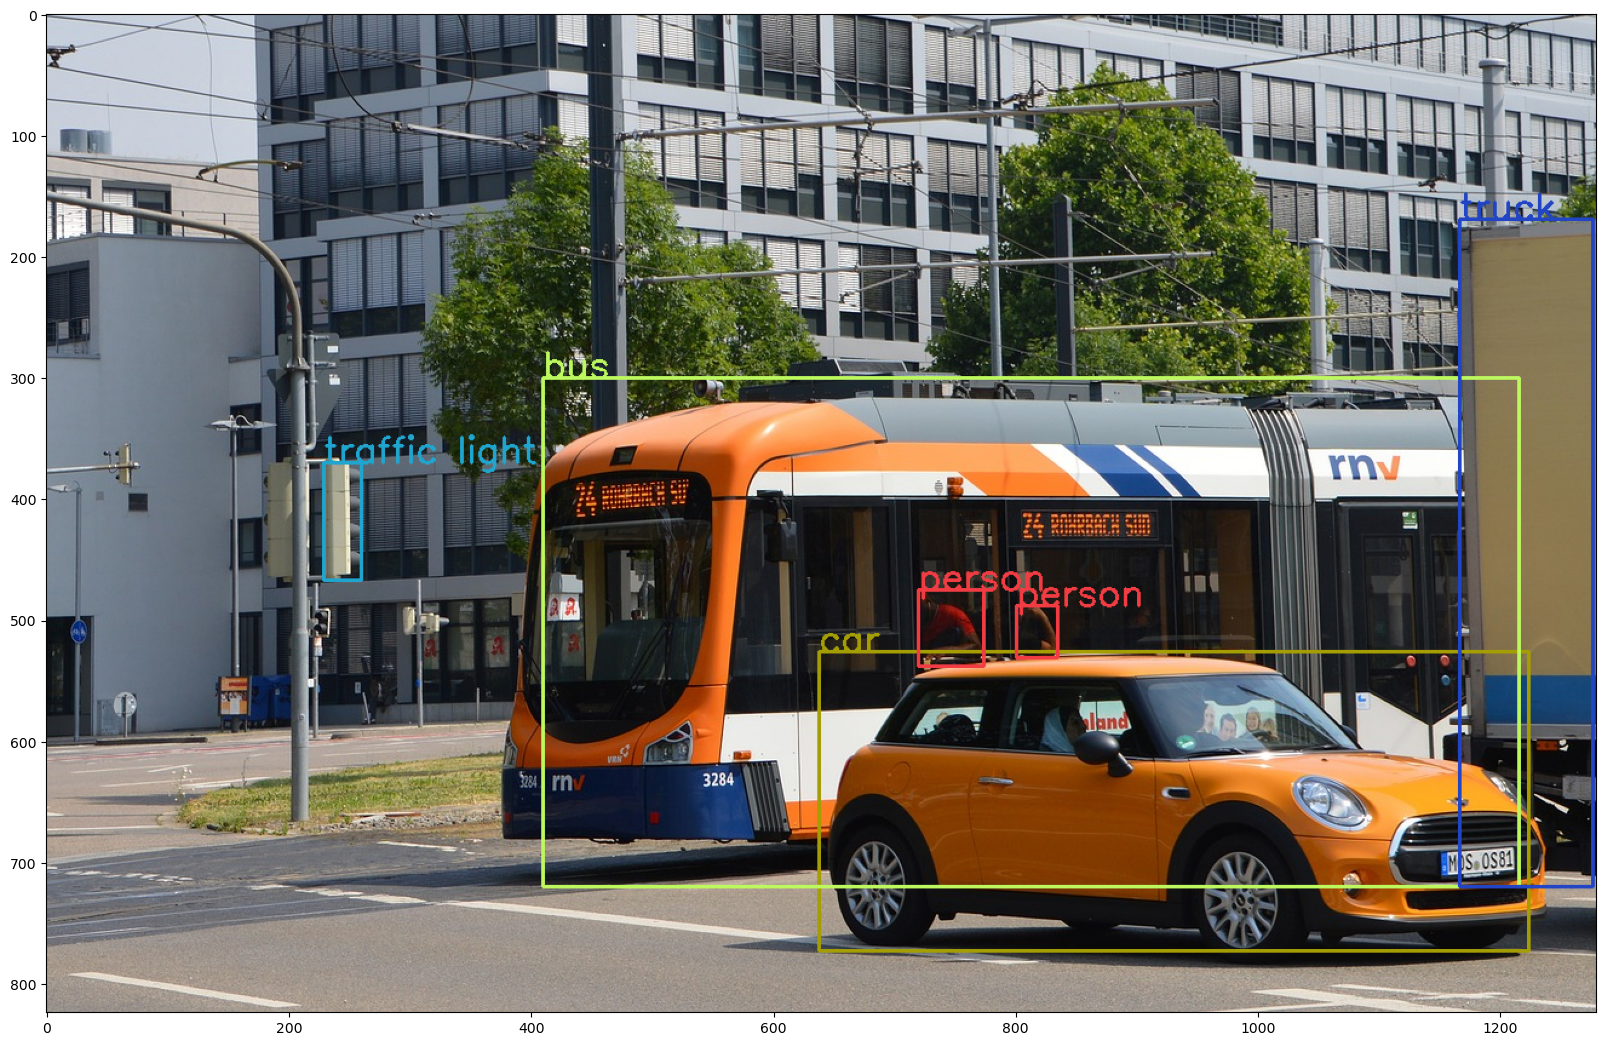

In [8]:
plt.figure(figsize=(20,20))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))